In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
import numpy as np
from tqdm import tqdm
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
import pandas as pd
import matplotlib.pyplot as plt
from statsmodels.stats.diagnostic import acorr_ljungbox
from statsmodels.tsa.stattools import acf, pacf
import seaborn as sns
from math import radians, sin, cos, sqrt, atan2
from sklearn.neighbors import BallTree
import math
from joblib import Parallel, delayed

In [ ]:
def get_device():
    if torch.cuda.is_available():
        # Get the number of available GPUs
        n_gpu = torch.cuda.device_count()
        print(f"Number of GPUs available: {n_gpu}")
        
        if n_gpu >= 3:  # If GPU 2 (index 2) is available
            print("Using GPU 2")
            return torch.device('cuda:2')
        elif n_gpu > 0:  # If any GPU is available
            print(f"GPU 2 not available, using GPU 0")
            return torch.device('cuda:0')
    
    print("No GPU available, using CPU")
    return torch.device('cpu')

class SpatialAttention(nn.Module):
    """
    Spatial attention mechanism based on geographical features
    """
    def __init__(self, input_dim):
        super().__init__()
        self.attention = nn.Sequential(
            nn.Linear(input_dim, 64),
            nn.ReLU(),
            nn.Linear(64, 1),
            nn.Sigmoid()
        )
        
    def forward(self, x):
        weights = self.attention(x)
        return x * weights

class TemporalEncoder(nn.Module):
    def __init__(self, price_history_dim, rolling_dim):
        super().__init__()
        
        # Price history processing
        self.price_history_gru = nn.GRU(
            input_size=1,
            hidden_size=32,
            num_layers=2,
            batch_first=True,
            dropout=0.2
        )
        
        # Rolling window processing
        self.rolling_encoder = nn.Sequential(
            nn.Linear(rolling_dim, 64),
            nn.ReLU(),
            nn.Dropout(0.2),
            nn.Linear(64, 32)
        )
        
        # Attention for combining temporal features
        self.temporal_attention = nn.Linear(64, 2)
        
    def forward(self, price_history, rolling_features):
        # Process price history
        price_history = price_history.unsqueeze(-1)  # Add feature dimension
        _, price_hidden = self.price_history_gru(price_history)
        price_encoding = price_hidden[-1]
        
        # Process rolling features
        rolling_encoding = self.rolling_encoder(rolling_features)
        
        # Combine using attention
        combined = torch.cat([price_encoding, rolling_encoding], dim=-1)
        attention_weights = torch.softmax(self.temporal_attention(combined), dim=-1)
        
        temporal_embedding = (
            attention_weights[:, 0:1] * price_encoding +
            attention_weights[:, 1:2] * rolling_encoding
        )
        
        return temporal_embedding

class EnhancedRealEstateTrainer:
    def __init__(self, feature_dims, device='cuda:2'):
        self.device = torch.device(device)
        self.model = EnhancedRealEstateNN(feature_dims).to(self.device)
        self.criterion = nn.MSELoss()
        self.optimizer = optim.Adam(self.model.parameters(), lr=0.001)
        
    def train_epoch(self, train_loader):
        self.model.train()
        total_loss = 0
        
        for batch in train_loader:
            # Move batch to GPU
            basic_spatial = batch['basic_spatial'].to(self.device)
            enhanced_spatial = batch['enhanced_spatial'].to(self.device)
            time = batch['time'].to(self.device)
            price_history = batch['price_history'].to(self.device)
            rolling = batch['rolling'].to(self.device)
            price = batch['price'].to(self.device)
            
            # Forward pass
            self.optimizer.zero_grad()
            output = self.model(basic_spatial, enhanced_spatial, time, price_history, rolling)
            loss = self.criterion(output.squeeze(), price)
            
            # Backward pass
            loss.backward()
            self.optimizer.step()
            
            total_loss += loss.item()
            
        return total_loss / len(train_loader)
    
    @torch.no_grad()
    def validate(self, val_loader):
        self.model.eval()
        total_loss = 0
        
        for batch in val_loader:
            # Move batch to GPU
            basic_spatial = batch['basic_spatial'].to(self.device)
            enhanced_spatial = batch['enhanced_spatial'].to(self.device)
            time = batch['time'].to(self.device)
            price_history = batch['price_history'].to(self.device)
            rolling = batch['rolling'].to(self.device)
            price = batch['price'].to(self.device)
            
            # Forward pass
            output = self.model(basic_spatial, enhanced_spatial, time, price_history, rolling)
            loss = self.criterion(output.squeeze(), price)
            
            total_loss += loss.item()
            
        return total_loss / len(val_loader)
    
    @torch.no_grad()
    def predict(self, test_loader):
        self.model.eval()
        predictions = []
        
        for batch in test_loader:
            # Move batch to GPU
            basic_spatial = batch['basic_spatial'].to(self.device)
            enhanced_spatial = batch['enhanced_spatial'].to(self.device)
            time = batch['time'].to(self.device)
            price_history = batch['price_history'].to(self.device)
            rolling = batch['rolling'].to(self.device)
            
            # Forward pass
            output = self.model(basic_spatial, enhanced_spatial, time, price_history, rolling)
            predictions.append(output.cpu().numpy())
            
        return np.concatenate(predictions).squeeze()

def train_enhanced_model(train_data, val_data, batch_size=32, epochs=100, device='cuda:2'):
    """
    Main training function for enhanced model
    """
    # Create datasets
    train_dataset = EnhancedRealEstateDataset(train_data)
    val_dataset = EnhancedRealEstateDataset(val_data)
    
    # Create data loaders
    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
    val_loader = DataLoader(val_dataset, batch_size=batch_size)
    
    # Initialize feature dimensions
    feature_dims = {
        'basic_spatial': 3,      # latitude, longitude, neighbourhood
        'enhanced_spatial': 8,   # new spatial features
        'time': 5,              # time-related features
        'price_history': 4,     # price history features
        'rolling': 12           # rolling window features
    }
    
    # Initialize trainer
    trainer = EnhancedRealEstateTrainer(feature_dims, device)
    
    # Training loop with early stopping
    best_val_loss = float('inf')
    patience = 10
    patience_counter = 0
    
    pbar = tqdm(range(epochs), desc='Training Enhanced Model')
    
    for epoch in pbar:
        train_loss = trainer.train_epoch(train_loader)
        val_loss = trainer.validate(val_loader)
        
        pbar.set_postfix({
            'train_loss': f'{train_loss:.4f}',
            'val_loss': f'{val_loss:.4f}',
            'patience': f'{patience_counter}/{patience}'
        })
        
        if val_loss < best_val_loss:
            best_val_loss = val_loss
            patience_counter = 0
            torch.save(trainer.model.state_dict(), 'best_enhanced_model.pth')
        else:
            patience_counter += 1
            if patience_counter >= patience:
                print("\nEarly stopping triggered!")
                break
    
    return trainer

class EnhancedRealEstateDataset(Dataset):
    def __init__(self, data):
        """
        Enhanced dataset handling both original and new spatial features
        Args:
            data: DataFrame with combined features
        """
        super().__init__()
        
        # Original spatial features
        self.basic_spatial = torch.FloatTensor(
            data[['latitude', 'longitude', 'neighbourhood_cleansed_encoded']].values
        )
        
        # New spatial features from create_spatial_features
        self.enhanced_spatial = torch.FloatTensor(data[[
            'distance_to_center', 'north_south', 'knn_price_mean',
            'knn_price_std', 'price_diff_from_neighbors', 'knn_price_median',
            'knn_price_range', 'distance_weighted_price'
        ]].values)
        
        # Time features
        self.time_features = torch.FloatTensor(data[[
            'DTF_day_of_week', 'DTF_month', 'DTF_is_weekend',
            'DTF_season_sin', 'DTF_season_cos'
        ]].values)
        
        # Price history features
        self.price_history = torch.FloatTensor(data[[
            'price_lag_90d', 'price_lag_120d', 
            'price_lag_150d', 'price_lag_180d'
        ]].values)
        
        # Rolling window features
        self.rolling_features = torch.FloatTensor(data[[
            'rolling_mean_30d', 'rolling_std_30d', 'rolling_max_30d', 'rolling_min_30d',
            'rolling_mean_60d', 'rolling_std_60d', 'rolling_max_60d', 'rolling_min_60d',
            'rolling_mean_90d', 'rolling_std_90d', 'rolling_max_90d', 'rolling_min_90d'
        ]].values)
        
        # Target
        self.price = torch.FloatTensor(data['price'].values)
        
    def __len__(self):
        return len(self.price)
    
    def __getitem__(self, idx):
        return {
            'basic_spatial': self.basic_spatial[idx],
            'enhanced_spatial': self.enhanced_spatial[idx],
            'time': self.time_features[idx],
            'price_history': self.price_history[idx],
            'rolling': self.rolling_features[idx],
            'price': self.price[idx]
        }

class EnhancedSpatialEncoder(nn.Module):
    def __init__(self, basic_dim, enhanced_dim):
        super().__init__()
        
        # Process basic spatial features
        self.basic_encoder = nn.Sequential(
            nn.Linear(basic_dim, 32),
            nn.ReLU(),
            nn.Dropout(0.2)
        )
        
        # Process enhanced spatial features
        self.enhanced_encoder = nn.Sequential(
            nn.Linear(enhanced_dim, 64),
            nn.ReLU(),
            nn.Dropout(0.2)
        )
        
        # Attention mechanism
        self.attention = nn.Sequential(
            nn.Linear(96, 32),  # 32 + 64 from both encoders
            nn.ReLU(),
            nn.Linear(32, 2),  # 2 attention weights
            nn.Softmax(dim=1)
        )
        
        # Final fusion
        self.fusion = nn.Linear(96, 32)
        
    def forward(self, basic_spatial, enhanced_spatial):
        # Encode both types of features
        basic_encoded = self.basic_encoder(basic_spatial)
        enhanced_encoded = self.enhanced_encoder(enhanced_spatial)
        
        # Concatenate for attention
        combined = torch.cat([basic_encoded, enhanced_encoded], dim=1)
        
        # Calculate attention weights
        weights = self.attention(combined)
        
        # Apply attention and fuse
        attended = torch.cat([
            basic_encoded * weights[:, 0:1],
            enhanced_encoded * weights[:, 1:2]
        ], dim=1)
        
        return self.fusion(attended)

class EnhancedRealEstateNN(nn.Module):
    def __init__(self, feature_dims):
        super().__init__()
        
        # Enhanced spatial processing
        self.spatial_encoder = EnhancedSpatialEncoder(
            basic_dim=feature_dims['basic_spatial'],
            enhanced_dim=feature_dims['enhanced_spatial']
        )
        
        # Other components remain the same
        self.time_encoder = nn.Sequential(
            nn.Linear(feature_dims['time'], 32),
            nn.ReLU(),
            nn.Dropout(0.2),
            nn.Linear(32, 16)
        )
        
        self.temporal_encoder = TemporalEncoder(
            price_history_dim=feature_dims['price_history'],
            rolling_dim=feature_dims['rolling']
        )
        
        # Final layers
        combined_dim = 32 + 16 + 32  # spatial + time + temporal
        self.final_layers = nn.Sequential(
            nn.Linear(combined_dim, 64),
            nn.ReLU(),
            nn.Dropout(0.3),
            nn.Linear(64, 32),
            nn.ReLU(),
            nn.Linear(32, 1)
        )
    
    def forward(self, basic_spatial, enhanced_spatial, time, price_history, rolling):
        # Process all features
        spatial_encoding = self.spatial_encoder(basic_spatial, enhanced_spatial)
        time_encoding = self.time_encoder(time)
        temporal_encoding = self.temporal_encoder(price_history, rolling)
        
        # Combine all features
        combined = torch.cat([
            spatial_encoding,
            time_encoding,
            temporal_encoding
        ], dim=1)
        
        # Final prediction
        return self.final_layers(combined)

In [3]:
def calculate_distance(lat1, lon1, lat2, lon2):
    """Calculate the distance between two points using the Haversine formula."""
    R = 6371  # Earth's radius in kilometers
    lat1, lon1, lat2, lon2 = map(radians, [lat1, lon1, lat2, lon2])
    dlat = lat2 - lat1
    dlon = lon2 - lon1
    a = sin(dlat/2)**2 + cos(lat1) * cos(lat2) * sin(dlon/2)**2
    c = 2 * atan2(sqrt(a), sqrt(1-a))
    return R * c

def create_spatial_features(df, k_neighbors=5, chunk_size=1000, n_jobs=-1):
    """Enhanced spatial features while maintaining existing structure"""
    city_center_lat, city_center_lon = 48.8566, 2.3522
    
    # Keep existing spatial features
    spatial_data = {
        'distance_to_center': [],
        'north_south': [],
        'knn_price_mean': [],
        'knn_price_std': [],
        'price_diff_from_neighbors': []
    }
    
    # Add new spatial features
    spatial_data.update({
        'knn_price_median': [],  # Add median as more robust metric
        'knn_price_range': [],   # Add price range in neighborhood
        'distance_weighted_price': []  # Add distance-weighted price
    })
    
    # Calculate basic distance features (keeping existing logic)
    spatial_data['distance_to_center'] = df.apply(
        lambda row: calculate_distance(
            row['latitude'], 
            row['longitude'], 
            city_center_lat, 
            city_center_lon
        ),
        axis=1
    ).values
    
    spatial_data['north_south'] = (df['latitude'] - city_center_lat).values
    
    # Enhanced BallTree processing
    all_coords = np.radians(df[['latitude', 'longitude']].values)
    tree = BallTree(all_coords, metric='haversine')
    all_prices = df['price'].values
    
    def enhanced_process_chunk(chunk_data, tree, k_neighbors, all_prices):
        """Enhanced chunk processing with additional metrics"""
        coords = np.radians(chunk_data[['latitude', 'longitude']].values)
        distances, indices = tree.query(coords, k=k_neighbors + 1)
        
        # Convert distances to weights (inverse distance weighting)
        weights = 1 / (distances[:, 1:] + 1e-6)  # Add small epsilon to avoid division by zero
        weights = weights / weights.sum(axis=1, keepdims=True)
        
        neighbor_prices = np.take(all_prices, indices[:, 1:])
        
        return {
            'knn_price_mean': np.nanmean(neighbor_prices, axis=1),
            'knn_price_std': np.nanstd(neighbor_prices, axis=1),
            'knn_price_median': np.nanmedian(neighbor_prices, axis=1),
            'knn_price_range': np.ptp(neighbor_prices, axis=1),
            'price_diff_from_neighbors': chunk_data['price'].values - np.nanmean(neighbor_prices, axis=1),
            'distance_weighted_price': np.sum(weights * neighbor_prices, axis=1)
        }
    
    # Split and process chunks (keeping existing logic)
    n_chunks = math.ceil(len(df) / chunk_size)
    chunks = np.array_split(df, n_chunks)
    
    results = Parallel(n_jobs=n_jobs)(
        delayed(enhanced_process_chunk)(
            chunk, 
            tree, 
            k_neighbors,
            all_prices
        ) for chunk in chunks
    )
    
    # Combine results with new features
    for key in spatial_data.keys():
        if key not in ['distance_to_center', 'north_south']:
            spatial_data[key] = np.concatenate([r[key] for r in results])
    
    spatial_features = pd.DataFrame(spatial_data, index=df.index)
    
    # Enhanced feature standardization
    features_to_standardize = list(spatial_data.keys())
    
    for col in features_to_standardize:
        spatial_features[col] = (spatial_features[col] - spatial_features[col].mean()) / spatial_features[col].std()
    
    return spatial_features

In [4]:
# Load preprocessed data
print("Loading preprocessed data...")
train_data = pd.read_csv(r'C:\Users\mvk\Documents\DATA_school\thesis\train_data_2024.csv')
test_data = pd.read_csv(r'C:\Users\mvk\Documents\DATA_school\thesis\test_data_2025.csv')
print("Data loaded successfully.")

# Reduce the number of unique listings for testing and development
n_train_listings = 500 
n_test_listings = 500

# Get random sample of unique listing IDs
train_listings = train_data['listing_id'].unique()
np.random.seed(42)
selected_train_listings = np.random.choice(train_listings, n_train_listings, replace=False)

# Filter train data to keep all rows for selected listings
train_data = train_data[train_data['listing_id'].isin(selected_train_listings)]

# Do the same for test data
test_listings = test_data['listing_id'].unique()
selected_test_listings = np.random.choice(test_listings, n_test_listings, replace=False)
test_data = test_data[test_data['listing_id'].isin(selected_test_listings)]

print(f"Reduced to {n_train_listings} training listings and {n_test_listings} test listings")
print(f"Training data shape: {train_data.shape}")
print(f"Test data shape: {test_data.shape}")

Loading preprocessed data...
Data loaded successfully.
Reduced to 500 training listings and 500 test listings
Training data shape: (172430, 27)
Test data shape: (30500, 27)


In [5]:
# Add spatial features
print("Creating spatial features for training data...")
train_spatial = create_spatial_features(train_data)
print("Spatial features for training data created.")

print("Creating spatial features for test data...")
test_spatial = create_spatial_features(test_data)
print("Spatial features for test data created.")

# Combine with existing features
print("Combining spatial features with existing features...")
X_train = pd.concat([train_data, train_spatial], axis=1)  # Keep all columns including price
X_test = pd.concat([test_data, test_spatial], axis=1)  # Keep all columns including price
print("Features combined.")

test_dates = pd.to_datetime(test_data['date'])

Creating spatial features for training data...


c:\Users\mvk\anaconda3\envs\Thesis\Lib\site-packages\numpy\_core\fromnumeric.py:57: FutureWarning: 'DataFrame.swapaxes' is deprecated and will be removed in a future version. Please use 'DataFrame.transpose' instead.
  return bound(*args, **kwds)


Spatial features for training data created.
Creating spatial features for test data...
Spatial features for test data created.
Combining spatial features with existing features...
Features combined.


c:\Users\mvk\anaconda3\envs\Thesis\Lib\site-packages\numpy\_core\fromnumeric.py:57: FutureWarning: 'DataFrame.swapaxes' is deprecated and will be removed in a future version. Please use 'DataFrame.transpose' instead.
  return bound(*args, **kwds)


In [13]:
# Train enhanced model
print("\nStarting enhanced model training...")
trainer = train_enhanced_model(X_train, X_test, batch_size=32, epochs=100, device=device)

# Evaluate on test set
print("\n=== Evaluating Enhanced Model ===")
print("Creating test dataset and loader...")
test_dataset = EnhancedRealEstateDataset(X_test)
test_loader = DataLoader(test_dataset, batch_size=32)

print("Making predictions...")
predictions = trainer.predict(test_loader)

# Update metrics calculation
true_prices = X_test['price'].values


Starting enhanced model training...


Training Enhanced Model:   9%|▉         | 9/100 [06:30<1:05:45, 43.36s/it, train_loss=0.0038, val_loss=nan, patience=9/10]



Early stopping triggered!

=== Evaluating Enhanced Model ===
Creating test dataset and loader...
Making predictions...


In [14]:
# Calculate metrics
true_prices = y_test.values
metrics = {
    'rmse': np.sqrt(mean_squared_error(true_prices, predictions)),
    'mae': mean_absolute_error(true_prices, predictions),
    'r2': r2_score(true_prices, predictions),
    'mape': np.mean(np.abs((true_prices - predictions) / true_prices)) * 100
}

# Print traditional metrics
print("\n=== Final Enhanced Model Performance ===")
for metric, value in metrics.items():
    print(f"{metric.upper()}: {value:.4f}")

# Additional spatiotemporal analysis
print("\n=== Spatiotemporal Analysis ===")

# Analyze temporal performance
monthly_performance = pd.DataFrame({
    'Date': pd.to_datetime(test_data['date']),
    'True': true_prices,
    'Predicted': predictions,
    'AbsError': np.abs(true_prices - predictions)
})
monthly_errors = monthly_performance.groupby(monthly_performance['Date'].dt.strftime('%Y-%m'))[['AbsError']].agg(['mean', 'std'])
print("\nMonthly Error Analysis:")
print(monthly_errors)

# Analyze spatial performance
spatial_performance = pd.DataFrame({
    'Neighborhood': test_data['neighbourhood_cleansed_encoded'],
    'AbsError': np.abs(true_prices - predictions)
})
neighborhood_errors = spatial_performance.groupby('Neighborhood')[['AbsError']].agg(['mean', 'std', 'count'])
print("\nNeighborhood Error Analysis:")
print(neighborhood_errors)

# Create visualization of errors over time and space
plt.figure(figsize=(15, 5))

# Temporal error plot
plt.subplot(1, 2, 1)
monthly_performance.set_index('Date')['AbsError'].rolling(window=7).mean().plot()
plt.title('7-Day Rolling Average of Absolute Error')
plt.xlabel('Date')
plt.ylabel('Absolute Error')

# Spatial error plot
plt.subplot(1, 2, 2)
neighborhood_errors['AbsError']['mean'].sort_values().plot(kind='bar')
plt.title('Mean Absolute Error by Neighborhood')
plt.xlabel('Neighborhood')
plt.ylabel('Mean Absolute Error')
plt.xticks(rotation=45)

plt.tight_layout()
plt.show()

# Save model and predictions
print("\nSaving model and predictions...")
torch.save(trainer.model.state_dict(), 'enhanced_model_final.pth')
np.save('enhanced_predictions.npy', predictions)

print("\nEvaluation complete!")

ValueError: Input contains NaN.


=== Error Autocorrelation Analysis ===

Error Autocorrelations:
Lag 1 day(s): nan
Lag 2 day(s): nan
Lag 3 day(s): nan
Lag 4 day(s): nan
Lag 5 day(s): nan
Lag 6 day(s): nan
Lag 7 day(s): nan


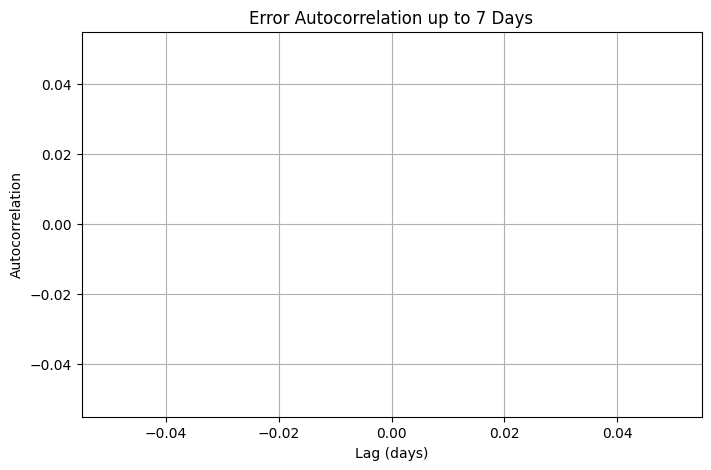

In [15]:
# After calculating basic metrics
print("\n=== Error Autocorrelation Analysis ===")

# Calculate error series
errors = true_prices - predictions
error_series = pd.Series(errors, index=pd.to_datetime(test_data['date']))

# Calculate autocorrelations for lags 1-7
lags = range(1, 8)  # 1 to 7 days
autocorrs = []

for lag in lags:
    autocorr = error_series.autocorr(lag=lag)
    autocorrs.append({
        'lag': lag,
        'autocorrelation': autocorr
    })

# Display results
print("\nError Autocorrelations:")
for result in autocorrs:
    print(f"Lag {result['lag']} day(s): {result['autocorrelation']:.4f}")

# Simple plot of autocorrelations
plt.figure(figsize=(8, 5))
plt.plot([r['lag'] for r in autocorrs], [r['autocorrelation'] for r in autocorrs], 'bo-')
plt.title('Error Autocorrelation up to 7 Days')
plt.xlabel('Lag (days)')
plt.ylabel('Autocorrelation')
plt.grid(True)
plt.show()